In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from datetime import datetime

respath = './Results/'
date = datetime.today().strftime('%d%m%y')

In [2]:
def read_res_sheets(file, respath='./Results/'):
    xl = pd.ExcelFile(respath+file)
    cohort = file.split('_')[0]
    for sheet in xl.sheet_names:
        # print(sheet)
        globals()[cohort+'_'+sheet] = xl.parse(sheet).set_index('term') # convert to dataframe
    
read_res_sheets('ALSPAC_Results_230223.xlsx')
read_res_sheets('GENR_Results_230223.xlsx')

In [3]:
# Set up size of text in figures
f1 = 20
f2 = 18
f3 = 14

lbls=['High internalizing','High adiposity', 'Comorbidity']
clrs=['royalblue','orange','indianred']

In [8]:
# subset the relevant compairison 
def subset(outc, cohort, els='ELS_z', comp='H:multim'):
    ms = {'exerc':'exercise_z','sleep':'sleep_hr_z','mdiet':'med_diet_z'}
    # Initiate dataframes   
    mainmod = pd.DataFrame(); mainels = pd.DataFrame(); interac = pd.DataFrame()
    # loop through moderator models
    for m in ms.keys():
        mod = globals()[cohort+'_'+m+'_'+outc]
        if outc in ['main','pren','post','bin1','bin2']:
            mod = mod.loc[mod['y.level']==comp]

        mainmod = pd.concat([mainmod, mod.loc[ms[m]]], axis=1)
        mainels = pd.concat([mainels, mod.loc[els]], axis=1)
        interac = pd.concat([interac, mod.loc[els+':'+ms[m]]], axis=1)

    return(mainmod.T, mainels.T, interac.T)

def subset_bin(outc, cohort, els='ELS_z', comp='H:multim'):
    ms = {'exerc':'exercise_bin1','sleep':'sleep_hr_bin1','mdiet':'med_diet_bin1'}
    # Initiate dataframes   
    mainels = pd.DataFrame(); revrels = pd.DataFrame(); mainmod = pd.DataFrame()
    # loop through moderator models
    for m in ms.keys():
        mod1 = globals()[cohort+'_'+m+'_'+outc+'1']; mod2 = globals()[cohort+'_'+m+'_'+outc+'2']
        if outc =='bin':
            mod1 = mod1.loc[mod1['y.level']==comp]; mod2 = mod2.loc[mod2['y.level']==comp]

        mainels = pd.concat([mainels, mod1.loc[els]], axis=1)
        revrels = pd.concat([revrels, mod2.loc[els]], axis=1)
        mainmod = pd.concat([mainmod, mod1.loc[ms[m]]], axis=1)

    return(mainels.T, revrels.T, mainmod.T)

In [10]:
b3 = subset_bin('bin', 'GENR', 'ELS_z')[2]
b3

,y.level,estimate,std.error,statistic,df,p.value,sign,OR,lci,uci,AIC
exercise_bin1,H:multim,-0.2779,0.2616,-1.0621,247.7431,0.2892,NaN,0.7574,0.4536,1.2647,NaN
sleep_hr_bin1,H:multim,-0.1475,0.3823,-0.3857,85.1823,0.7007,NaN,0.8629,0.4079,1.8254,NaN
med_diet_bin1,H:multim,-0.1461,0.2493,-0.5862,120.942,0.5588,NaN,0.8641,0.5301,1.4085,NaN


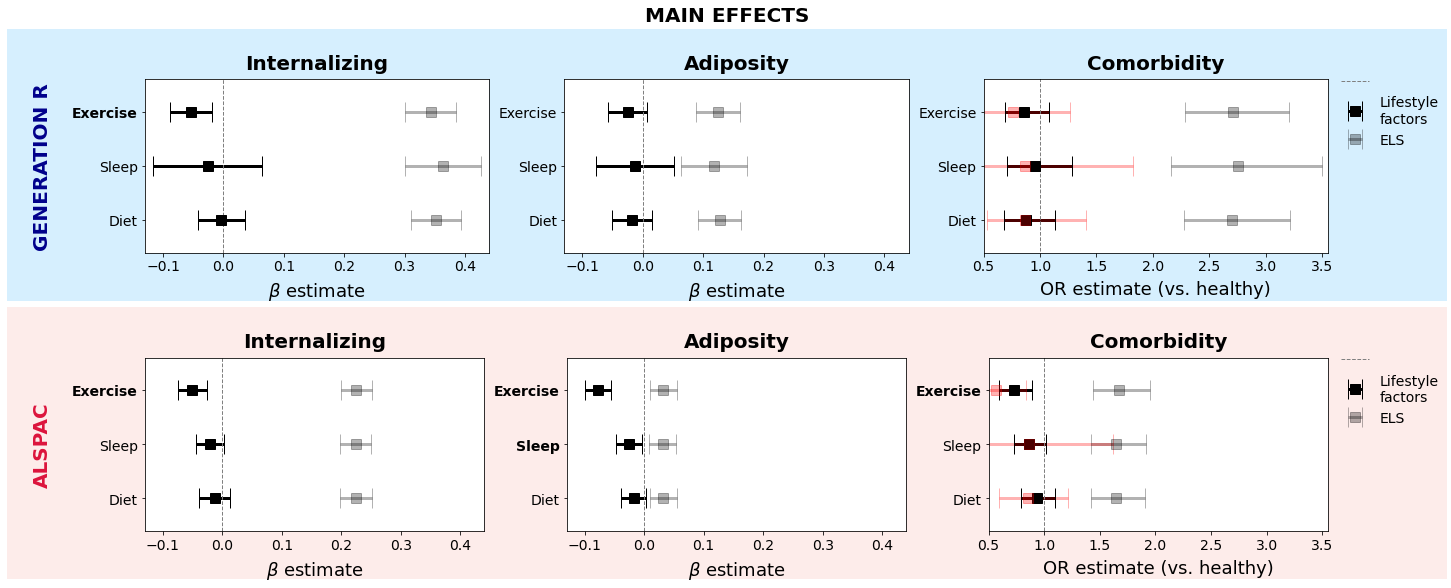

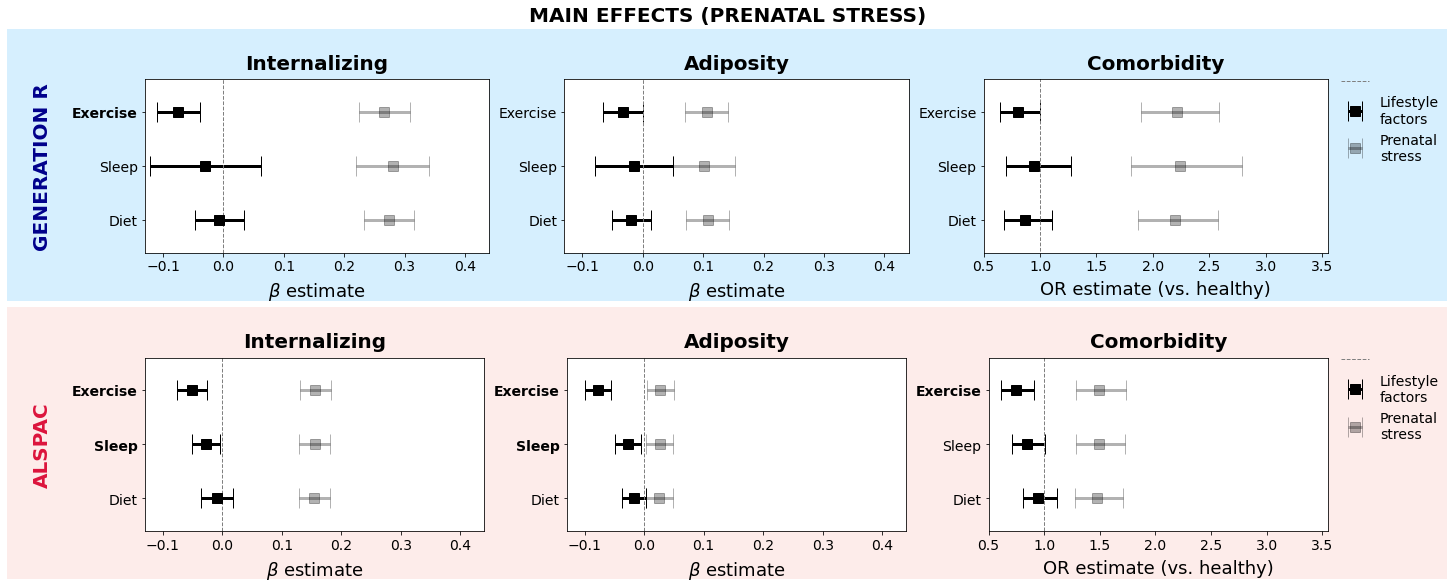

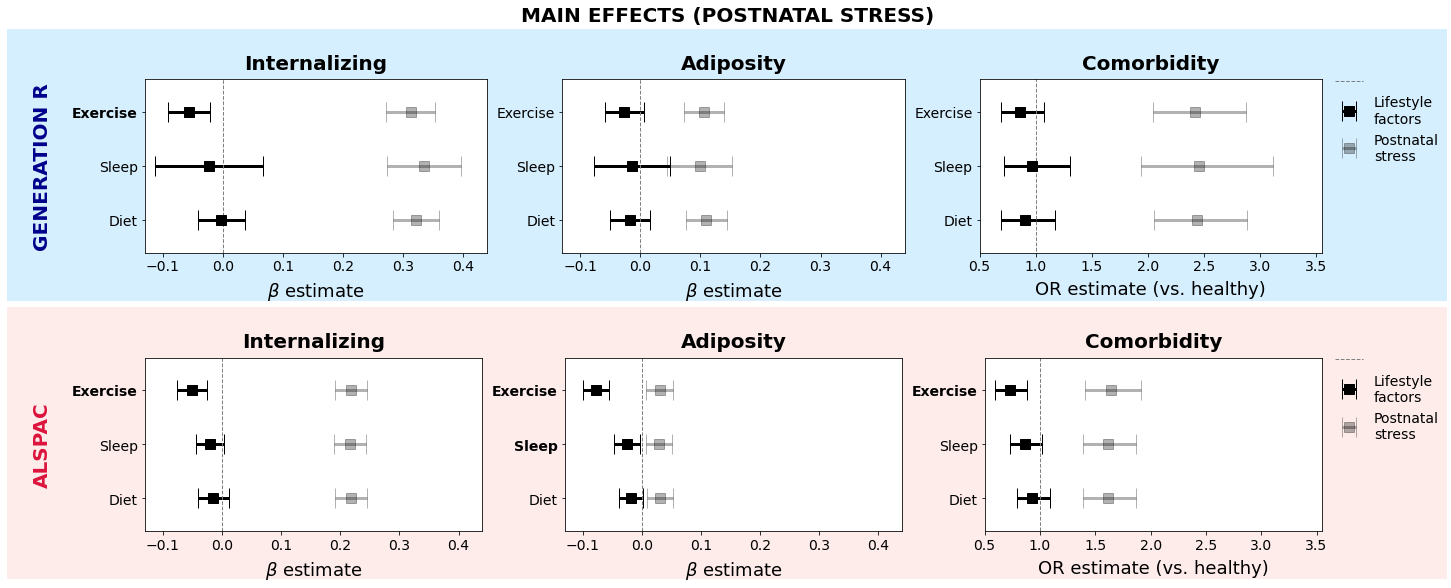

In [11]:
def plot_main(axs, cohort, els='ELS_z', comp='H:multim'):
    
    mods=['intr','fatm','main']; stress_label='ELS'
    
    if els == 'prenatal_stress_z': mods = ['intr_pren','fatm_pren','pren']; stress_label='Prenatal\nstress'
    elif els == 'postnatal_stress_z': mods = ['intr_post','fatm_post','post']; stress_label='Postnatal\nstress'
    
    m1,e1,_ = subset(mods[0], cohort, els)
    m2,e2,_ = subset(mods[1], cohort, els)
    m3,e3,_ = subset(mods[2], cohort, els)
    
    if els=='ELS_z':
        b3 = subset_bin('bin', cohort, 'ELS_z')[2]

    ax1,ax2,ax3 = axs
    
    mod_labels = ['Exercise','Sleep','Diet']
    
    # Plot betas inernalizing
    ax1.errorbar(m1['estimate'], mod_labels, xerr = list(m1['std.error']*1.96), color='black',
                 fmt='s', ms=10, elinewidth=3, capsize=10)
    ax1.errorbar(e1['estimate'], mod_labels, xerr = list(e1['std.error']*1.96), color='black',
                 fmt='s', ms=10, elinewidth=3, capsize=10, alpha=0.3)
    # Plot betas adiposity
    ax2.errorbar(m2['estimate'], mod_labels, xerr = list(m2['std.error']*1.96), color='black',
                 fmt='s', ms=10, elinewidth=3, capsize=10)
    ax2.errorbar(e2['estimate'], mod_labels, xerr = list(e2['std.error']*1.96), color='black',
                 fmt='s', ms=10, elinewidth=3, capsize=10, alpha=0.3)
    # Plot OR comorbidity
    ax3.errorbar(m3['OR'], mod_labels, xerr = [m3['OR']-m3['lci'], m3['uci']-m3['OR']], color='black',
                 fmt='s', ms=10, elinewidth=3, capsize=10)
    ax3.errorbar(e3['OR'], mod_labels, xerr = [e3['OR']-e3['lci'], e3['uci']-e3['OR']], color='black',
                 fmt='s', ms=10, elinewidth=3, capsize=10, alpha=0.3)
    if els=='ELS_z':
        ax3.errorbar(b3['OR'], mod_labels, xerr = [b3['OR']-b3['lci'], b3['uci']-b3['OR']], color='red',
                 fmt='s', ms=10, elinewidth=3, capsize=10, alpha=0.3)
    
    #add a vertical dotted line indicating beta = 0 or OR = 1.
    ax1.axvline(x = 0, color = 'grey', ls = '--', lw = 1)
    ax2.axvline(x = 0, color = 'grey', ls = '--', lw = 1)
    ax3.axvline(x = 1, ymin = -1, ymax = 4, color = 'grey', ls = '--', lw = 1)
    
    # Add x axis limit 
    ax1.set_xlim(-0.13,0.44); ax2.set_xlim(-0.13,0.44); ax3.set_xlim(0.5,3.55)
    
    # Add legend
    ax3.legend(['','Lifestyle\nfactors',stress_label], fontsize=f3, 
               bbox_to_anchor=(1, 1.1), loc='upper left',ncol=1, framealpha=0)
    
    titles = ['Internalizing', 'Adiposity', 'Comorbidity']
    xlables = [r'$\beta $ estimate',r'$\beta $ estimate','OR estimate (vs. healthy)']
    
    for n,ax in enumerate(axs):
        ax.set_ylim(-0.6,2.6)
        # add x-label 
        ax.set_xlabel(xlables[n], fontsize = f2, labelpad=7)
        # add a title 
        ax.set_title('\n'+titles[n], fontweight = 'bold', fontsize = f1, pad=10)
        # adjust axis parameter
        ax.tick_params(axis='both', which='major', labelsize = f3)
        # invert axis
        ax.invert_yaxis()
    
    # bold significant
    def bold_sign(m, ax):
        sign = m.reset_index().index[m['p.value']<0.050].to_list()
        for pos in sign:
            ax.get_yticklabels()[pos].set_weight("bold") 
    
    bold_sign(m1, ax1); bold_sign(m2, ax2); bold_sign(m3, ax3);
    
# =====================================================
f = plt.figure(constrained_layout=True, figsize=(20, 8))

f.suptitle('MAIN EFFECTS', fontsize=f1, fontweight='bold')

subf1, subf2 = f.subfigures(2, 1, wspace=0.2)
subf1.set_facecolor('#D6EFFE') # lightblue
subf2.set_facecolor('#FDECEA') # pink

axs1 = subf1.subplots(1, 3)
axs2 = subf2.subplots(1, 3)

plot_main(axs1, 'GENR')
plot_main(axs2, 'ALSPAC')

axs1[0].set_ylabel("\nGENERATION R", fontsize=f1, fontweight='bold', labelpad=20, color='darkblue')
axs2[0].set_ylabel("\nALSPAC", fontsize=f1, fontweight='bold', labelpad=20, color='crimson')

f.savefig(respath+'2.Main-effects.pdf', dpi=400)

# =====================================================
f = plt.figure(constrained_layout=True, figsize=(20, 8))

f.suptitle('MAIN EFFECTS (PRENATAL STRESS)', fontsize=f1, fontweight='bold')

subf1, subf2 = f.subfigures(2, 1, wspace=0.2)
subf1.set_facecolor('#D6EFFE') # lightblue
subf2.set_facecolor('#FDECEA') # pink

axs1 = subf1.subplots(1, 3)
axs2 = subf2.subplots(1, 3)

plot_main(axs1, 'GENR', els='prenatal_stress_z')
plot_main(axs2, 'ALSPAC', els='prenatal_stress_z')

axs1[0].set_ylabel("\nGENERATION R", fontsize=f1, fontweight='bold', labelpad=20, color='darkblue')
axs2[0].set_ylabel("\nALSPAC", fontsize=f1, fontweight='bold', labelpad=20, color='crimson')

f.savefig(respath+'4.Prenatal.pdf', dpi=400)

# =====================================================
f = plt.figure(constrained_layout=True, figsize=(20, 8))

f.suptitle('MAIN EFFECTS (POSTNATAL STRESS)', fontsize=f1, fontweight='bold')

subf1, subf2 = f.subfigures(2, 1, wspace=0.2)
subf1.set_facecolor('#D6EFFE') # lightblue
subf2.set_facecolor('#FDECEA') # pink

axs1 = subf1.subplots(1, 3)
axs2 = subf2.subplots(1, 3)

plot_main(axs1, 'GENR', els='postnatal_stress_z')
plot_main(axs2, 'ALSPAC', els='postnatal_stress_z')

axs1[0].set_ylabel("\nGENERATION R", fontsize=f1, fontweight='bold', labelpad=20, color='darkblue');
axs2[0].set_ylabel("\nALSPAC", fontsize=f1, fontweight='bold', labelpad=20, color='crimson');

f.savefig(respath+'5.Postnatal.pdf', dpi=400)

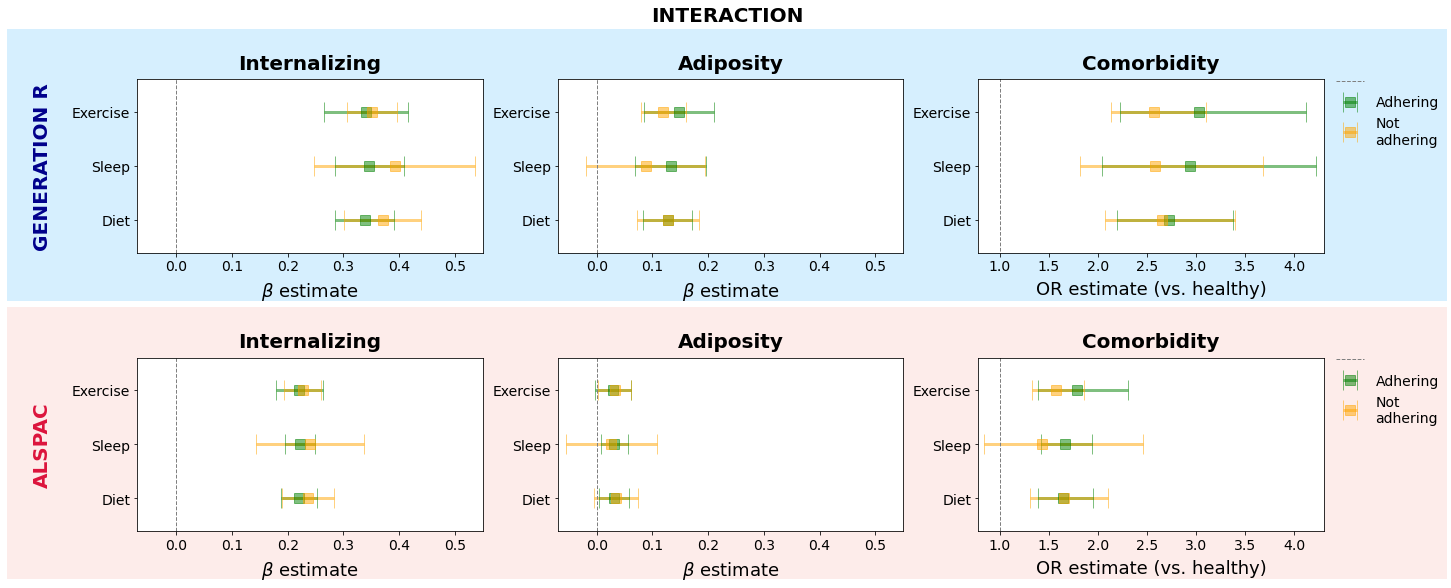

In [13]:
def plot_inter(axs, cohort, els='ELS_z', comp='H:multim'):
    
    m1,r1,_ = subset_bin('intr_bin', cohort, els)
    m2,r2,_ = subset_bin('fatm_bin', cohort, els)
    m3,r3,_ = subset_bin('bin', cohort, els)

    ax1,ax2,ax3 = axs
    
    mod_labels = ['Exercise','Sleep','Diet']
    
    # Plot betas inernalizing
    ax1.errorbar(r1['estimate'], mod_labels, xerr = list(r1['std.error']*1.96), color='green',
                 fmt='s', ms=10, elinewidth=3, capsize=10, alpha=0.5)
    ax1.errorbar(m1['estimate'], mod_labels, xerr = list(m1['std.error']*1.96), color='orange',
                 fmt='s', ms=10, elinewidth=3, capsize=10, alpha=0.5)
    # Plot betas adiposity
    ax2.errorbar(r2['estimate'], mod_labels, xerr = list(r2['std.error']*1.96), color='green',
                 fmt='s', ms=10, elinewidth=3, capsize=10, alpha=0.5)
    ax2.errorbar(m2['estimate'], mod_labels, xerr = list(m2['std.error']*1.96), color='orange',
                 fmt='s', ms=10, elinewidth=3, capsize=10, alpha=0.5)
    # Plot OR comorbidity
    ax3.errorbar(r3['OR'], mod_labels, xerr = [r3['OR']-r3['lci'], r3['uci']-r3['OR']], color='green',
                 fmt='s', ms=10, elinewidth=3, capsize=10, alpha=0.5)
    ax3.errorbar(m3['OR'], mod_labels, xerr = [m3['OR']-m3['lci'], m3['uci']-m3['OR']], color='orange',
                 fmt='s', ms=10, elinewidth=3, capsize=10, alpha=0.5)
    
    #add a vertical dotted line indicating beta = 0 or OR = 1.
    ax1.axvline(x = 0, color = 'grey', ls = '--', lw = 1)
    ax2.axvline(x = 0, color = 'grey', ls = '--', lw = 1)
    ax3.axvline(x = 1, ymin = -1, ymax = 4, color = 'grey', ls = '--', lw = 1)
    
    # Add x axis limit 
    ax1.set_xlim(-0.07,0.55); ax2.set_xlim(-0.07,0.55); ax3.set_xlim(0.78,4.3)
    
    # Add legend
    ax3.legend(['','Adhering','Not\nadhering'], fontsize=f3, 
               bbox_to_anchor=(1, 1.1), loc='upper left',ncol=1, framealpha=0)
    
    titles = ['Internalizing', 'Adiposity', 'Comorbidity']
    xlables = [r'$\beta $ estimate',r'$\beta $ estimate','OR estimate (vs. healthy)']
    
    for n,ax in enumerate(axs):
        ax.set_ylim(-0.6,2.6)
        # add x-label 
        ax.set_xlabel(xlables[n], fontsize = f2, labelpad=7)
        # add a title 
        ax.set_title('\n'+titles[n], fontweight = 'bold', fontsize = f1, pad=10)
        # adjust axis parameter
        ax.tick_params(axis='both', which='major', labelsize = f3)
        # invert axis
        ax.invert_yaxis()

# =====================================================
f = plt.figure(constrained_layout=True, figsize=(20, 8))

f.suptitle('INTERACTION', fontsize=f1, fontweight='bold')

subf1, subf2 = f.subfigures(2, 1, wspace=0.2)
subf1.set_facecolor('#D6EFFE') # lightblue
subf2.set_facecolor('#FDECEA') # pink

axs1 = subf1.subplots(1, 3)
axs2 = subf2.subplots(1, 3)

plot_inter(axs1, 'GENR')
plot_inter(axs2, 'ALSPAC')

axs1[0].set_ylabel("\nGENERATION R", fontsize=f1, fontweight='bold', labelpad=20, color='darkblue');
axs2[0].set_ylabel("\nALSPAC", fontsize=f1, fontweight='bold', labelpad=20, color='crimson');

f.savefig(respath+'3.Strat-effects.pdf', dpi=400)

<ipython-input-14-0aadb41610d6>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(7,16)), fontsize=f3)
<ipython-input-14-0aadb41610d6>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(7,16)), fontsize=f3)
<ipython-input-14-0aadb41610d6>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(7,16)), fontsize=f3)
<ipython-input-14-0aadb41610d6>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(xlbs), fontsize=f3)
<ipython-input-14-0aadb41610d6>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(xlbs), fontsize=f3)
<ipython-input-14-0aadb41610d6>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(xlbs), fontsize=f3)
<ipython-input-14-0aadb41610d6>:57: U

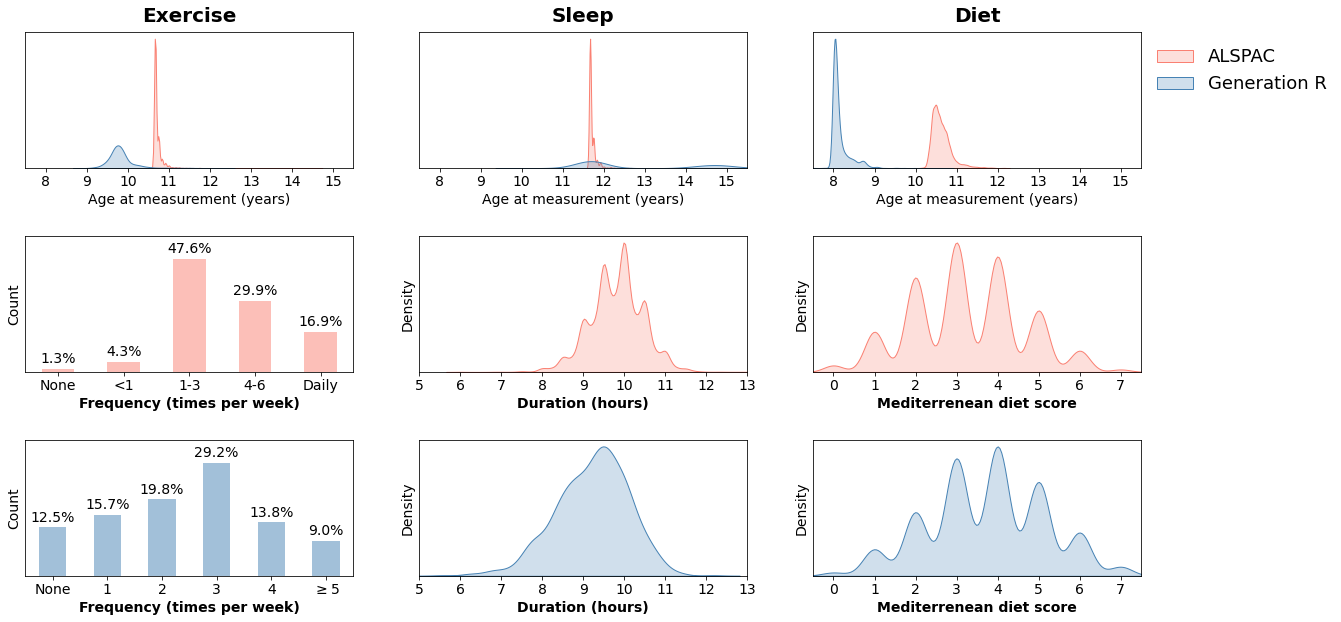

In [14]:
ALSP = pd.read_csv('./Data/byimp/imp0.csv')
GENR =  pd.read_csv('./Data/-GenR/byimp/imp0.csv')

f = plt.figure(constrained_layout=True, figsize=(20, 10))
[y1,y2,y3],[ax1,ax2,ax3],[gx1,gx2,gx3] = f.subplots(3, 3)

# f = plt.figure(constrained_layout=True, figsize=(20, 8))

# f.suptitle('Descriptives', fontsize=f1, fontweight='bold')

# subf1, subf2 = f.subfigures(2, 1, wspace=0.2)
# subf1.set_facecolor('#D6EFFE') # lightblue
# subf2.set_facecolor('#FDECEA') # pink

# axs1 = subf1.subplots(1, 3)
# axs2 = subf2.subplots(1, 3)

# axs1[0].set_ylabel("\nGENERATION R", fontsize=f1, fontweight='bold', labelpad=20, color='darkblue');
# axs2[0].set_ylabel("\nALSPAC", fontsize=f1, fontweight='bold', labelpad=20, color='crimson');

def ages_plot(var, ax, title):
    sns.kdeplot(ALSP[var+'_age'], ax=ax, color='salmon', shade=True, linewidth=1)
    sns.kdeplot(GENR[var+'_age'], ax=ax, color='steelblue', shade=True, linewidth=1)
    ax.set_xlabel('Age at measurement (years)', fontsize=f3)
    ax.set_ylabel(''); ax.set_yticks([])
    ax.set_xlim(7.5,15.5)
    ax.set_xticklabels(list(range(7,16)), fontsize=f3)
    ax.set_title(title, fontsize=f1, fontweight='bold', pad=10)

def hist_exerc(cohort, ax):
    lvls = ['none','<1 week','1-3 week','4-6 week','daily'] if cohort=='ALSP' else ['none','1 week','2 week','3 week','4 week','>=5 week']
    lbls = ['None','<1','1-3','4-6','Daily'] if cohort=='ALSP' else ['None','1','2','3','4',r'$\geq$5']
    colr = 'salmon' if cohort=='ALSP' else 'steelblue'
    df = globals()[cohort]['exercise_fac'].value_counts().loc[lvls]
    p = df.plot.bar(ax=ax, color=colr, alpha=0.5)
    
    for i, val in enumerate(df):
        perc = round(val/df.sum()*100,1)
        p.text(i, val+(df.max()/20), str(perc)+'%', ha='center', fontsize=f3)
    
    p.set_xticklabels(lbls, rotation=0, fontsize=f3)
    p.set_yticks([])
    p.set_ylim(0,df.max()+(df.max()/5))
    p.set_xlabel('Frequency (times per week)', fontsize=f3, fontweight='bold')
    p.set_ylabel('Count', fontsize=f3)

def dense_plot(cohort, var, ax):
    colr = 'salmon' if cohort=='ALSP' else 'steelblue'
    title, xlab, xlim = ['Diet','Mediterrenean diet score',(-0.5,7.5)] if var =='med_diet' else [
                         'Sleep','Duration (hours)',(5,13)]
    df = globals()[cohort]
    sns.kdeplot(df[var], ax=ax, color=colr, shade=True, linewidth=1)
    ax.set_xlabel(xlab, fontsize=f3, fontweight='bold')
    ax.set_ylabel('Density', fontsize=f3)
    ax.set_yticks([])
    xlbs = range(-1,8) if var=='med_diet' else range(xlim[0],xlim[1]+1)
    ax.set_xticklabels(list(xlbs), fontsize=f3)
    ax.set_xlim(xlim)    

ages_plot('exercise', y1, 'Exercise')
ages_plot('sleep_hr', y2, 'Sleep')
ages_plot('med_diet', y3, 'Diet')
y3.legend(['ALSPAC','Generation R'], fontsize=f2, bbox_to_anchor=(1, 1), loc='upper left',ncol=1, framealpha=0)

hist_exerc('ALSP', ax1)
hist_exerc('GENR', gx1)

dense_plot('ALSP','sleep_hr',ax2)
dense_plot('GENR','sleep_SR',gx2)

dense_plot('ALSP','med_diet',ax3)
dense_plot('GENR','med_diet',gx3)

f.subplots_adjust(hspace=0.5)

f.savefig(respath+'1.Mod-descr.pdf', dpi=400, bbox_inches='tight')


In [ ]:
A = pd.read_csv('./Data/byimp/imp30.csv')
G =  pd.read_csv('./Data/-GenR/byimp/imp30.csv')

In [ ]:
d = pd.read_csv('./Data/byimp/imp30.csv')

cohort='ALSPAC'

ms = {'exerc':'exercise_z','sleep':'sleep_hr_z','mdiet':'med_diet_z'}

m= 'exerc'
exp='ELS_z'
mod='exercise_z'
out='intern_score_13_z'
outc = 'intr'

# To prepare for visualization, we constract a regular grid covering the domain of the data

# Create data array with X = all predictors
# Note: .values converts pandas series object into array so we can use linalg on it later
pred = d[[exp, mod, 'age_child','sex', 'ethnicity','m_bmi_before_pregnancy','m_smoking','m_drinking']].values # 

# Obtain ranges of prenatal and postnatal stress
mn = np.min(pred, axis=0); mx = np.max(pred, axis=0)
# Create a 20x20 grid within stress ranges 
X,Y = np.meshgrid(np.linspace(mn[0], mx[0], 20), np.linspace(mn[1], mx[1], 20))
XX = X.flatten()
YY = Y.flatten()
    
# Define the prediction matrix (i.e., 1st model adjusted for age and sex)
A = np.c_[np.ones(pred.shape[0]), pred, np.prod(pred[:,:2], axis=1)]

# Get the betas from the pooled analysis in script 4-Regressions.R
bs_int = np.array(GENR_exerc_intr['estimate'])
bs_fat = np.array(GENR_exerc_fatm['estimate'])

# Evaluate it on a grid
Zi = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY], bs_int[[0,1,2,9]]).reshape(X.shape)
Zf = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY], bs_fat[[0,1,2,9]]).reshape(X.shape)

# ============================================
f = plt.figure(figsize = (20, 6))
# Define subplots 
ax1 = f.add_subplot(131); ax2 = f.add_subplot(132); ax3 = f.add_subplot(133, projection='3d')
# ax4 = f.add_subplot(234); ax5 = f.add_subplot(235); ax6 = f.add_subplot(236, projection='3d')


# Scatterplot
ax1.plot(d[exp], d[out], 'o', color = 'k', alpha = 0.1)
ax2.plot(d[mod], d[out], 'o', color = 'k', alpha = 0.1)
# Add a grid 
#ax.grid()
bs = globals()[cohort+'_'+m+'_'+outc]
b0 = bs.loc['(Intercept)','estimate']
b1 = bs.loc[exp,'estimate']
b2 = bs.loc[mod,'estimate']

# Regression line
ax1.plot(d[exp], b1+(b1*d[exp]), color = 'blue', lw = 2.5)
ax2.plot(d[mod], b2+(b2*d[mod]), color = 'red', lw = 2.5)

ax3.scatter(d[exp], d[mod], d[out], s = 20, alpha = 0.1, facecolors='none', edgecolors='k')
# Regression surface
ax3.plot_surface(X, Y, Zi, rstride = 2, cstride = 2, cmap='magma', alpha = 0.4) # edgecolor = 'yellow', color = 'yellow', alpha = 0.3)
# Main effect lines 
ax3.plot(d[exp], np.zeros(d.shape[0]), b1*d[exp]+b1, c = 'blue', lw = 2.5) 
ax3.plot(np.zeros(d.shape[0]), d[mod], b2*d[mod]+b2, c = 'red', lw = 2.5) 
ax3.invert_xaxis()
# Adjust the plot size to fit the 2D plots 
ax3.dist = 8 # higher numbers, smaller plots



In [ ]:
def stress2D(ax, outcome, stressor):
    '''This function creates classic (2D) regression graphs: i.e. a scatterplot of the exposure vs outcome 
       + regression line illustrating the main effect of exposure on outcome '''
    
    # outcome variable names and betas dataframe
    out = 'intern_score_13_z' if outcome == 'Internalizing' else 'fat_mass_z'
    bs = bs_int if outcome == 'Internalizing' else bs_fat
    # exposure variable names and betas dataframe
    exp = 'prenatal_stress_z' if stressor == 'Prenatal stress'else 'postnatal_stress_z'
    beta_pos = 1 if stressor == 'Prenatal stress' else 2
    
    # Define range of values for axis limits 
    out_mn = np.min(np.min(d[['intern_score_z', 'fat_mass_z']], axis = 0))
    out_mx = np.max(np.max(d[['intern_score_z', 'fat_mass_z']], axis = 0))
    # Set axis limits 
    ax.set_xlim([mn[1] - 0.1, mx[1] + 0.1])  # stress boundaries
    ax.set_ylim([out_mn - 0.1, out_mx + 0.1]) # z score boundaries
    # Scatterplot
    ax.plot(d[exp], d[out], 'o', color = 'k', alpha = 0.1)
    # Regression line
    ax.plot(d[exp], bs[beta_pos]*d[exp] + bs[0], color = cols[0] if exp == 'prenatal_stress_z' else cols[1], lw = 2.5)
    # Add a grid 
    ax.grid()
    # Set labels for the axes
    ax.set_xlabel(stressor, fontsize = 17, fontweight = 'bold')
    ax.set_ylabel(outcome, fontsize = 17, fontweight = 'bold')
    # ax.set_title(stressor, fontsize = 20, fontweight = 'bold')
# ------------------------------------------------------------------------------------------------------- #   

def stress3D(ax, outcome):
    ''' This function creates a 3D model rapresentation: i.e. a scatterplot of the exposure vs outcome 
       + fitted regression surface illustrating the interaction between two predictors as well as the 
       respective main effects (colored lines)'''
    
    # outcome variable names, betas dataframe and fitted surface
    var = 'intern_score_13_z' if outcome == 'Internalizing' else 'fat_mass_z'
    bs = bs_int if outcome == 'Internalizing' else bs_fat
    Z = Zi if outcome == 'Internalizing' else Zf
    
    # Set axis limits for the outcome (z axis)
    ax.set_zlim([-1, 6])
    # 3D Scatterplot
    ax.scatter(d.prenatal_stress_z, d.postnatal_stress_z, d[var], s = 20, alpha = 0.1, facecolors='none', edgecolors='k')
    # Regression surface
    ax.plot_surface(X, Y, Z, rstride = 2, cstride = 2, cmap='magma', alpha = 0.4) # edgecolor = 'yellow', color = 'yellow', alpha = 0.3)
    # Main effect lines 
    ax.plot(d.prenatal_stress_z, np.zeros(d.shape[0]), bs[1]*d.prenatal_stress_z + bs[0], c = cols[0], lw = 2.5) 
    ax.plot(np.zeros(d.shape[0]), d.postnatal_stress_z, bs[2]*d.postnatal_stress_z + bs[0], c = cols[1], lw = 2.5) 
    # Set labels for the axes
    ax.set_xlabel('Prenatal ELS', fontsize = 17, fontweight = 'bold')
    ax.set_ylabel('Postnatal ELS', fontsize = 17, fontweight = 'bold')
    ax.set_zlabel(outcome, fontsize = 17, fontweight = 'bold')
    # Invert x axis to have low values of both variables in the front corner
    ax.invert_xaxis()
    # Adjust the plot size to fit the 2D plots 
    ax.dist = 8 # higher numbers, smaller plots


In [ ]:
# GET THE DATASET (i.e., 30th imputation)
data = read_and_clean('ELSPCM_imputed.rds')
# print(data.columns.tolist())

# Select only some useful columns
d = data[['pre_life_events', 'pre_contextual_risk', 'pre_personal_stress', 'pre_interpersonal_stress', 
          'post_life_events', 'post_contextual_risk', 'post_parental_risk', 'post_interpersonal_risk', 'post_direct_victimization',
          'prenatal_stress', 'postnatal_stress', 'prenatal_stress_z', 'postnatal_stress_z', 
          'intern_score_z', 'fat_mass_z', 'risk_groups', 'sex', 'age_child']]
# d.head(3)

# GET THE POOLED ESTIMATES 
# extract the summary results created in script 4-Regressions.R
int_min = pd.read_excel(pathtodata+'Results.xlsx', sheet_name="1.intern_min")
fat_min = pd.read_excel(pathtodata+'Results.xlsx', sheet_name="3.fatmas_min")
grp_min = pd.read_excel(pathtodata+'Results.xlsx', sheet_name="5.riskgrp_min")

In [ ]:
from scipy import interpolate

# Fit the spline
def splineit(imp, exp, outc, ax, knot_number = 4, color='#41ab5d'):
    # read in imputed dataset and sort by exposure values
    d = pd.read_csv('./Data/byimp/imp'+str(imp)+'.csv').sort_values(by=exp.lower()+'_z')
    x = d[exp.lower()+'_z']
    y = d[outc.lower()+'_z']
    # determine where are the knots 
    x_new = np.linspace(0, 1, knot_number+2)[1:-1] # knot_number equally spaced values from 0-1
    q_knots = np.quantile(x, x_new) # use them to define quantiles of x
    # fit the spline 
    t,c,k = interpolate.splrep(x, y, t=q_knots, s=1)
    yfit = interpolate.BSpline(t,c,k)(x) 
    # plot the spline line 
    ax.plot(x, yfit, color=color, lw=2.5, alpha=0.3)

def predY(exp, outc, ax, cutoff=5.1, col='#41ab5d', col_outcome=False, rep_yaxis=False, ms=5, f1=20, f2=18):
    # in the non-imputed set:
    x = dat[exp.lower()+'_z']
    y = dat[outc.lower()+'_z']
    # extract linear regression estimate from results table 
    res = globals()[exp].loc[globals()[exp]['outcome']==outc]
    inter = res['estimate'].loc['(Intercept)'].iloc[1]
    slope = res['estimate'].loc[exp.lower()+'_9_z'].iloc[1]
    
    # scatter plot 
    if col_outcome:
        c = '#82adff' if outc=='TBV' else 'grey' if outc=='GMV' else '#fcbba1' if outc=='MFA' else '#fed976' #ffeda0'
    else:
        c = 'grey'
    ax.plot(x, y, 'o', color=c, ms=ms, alpha=0.2)
    
    # nonlinear relation 
    for imp in range(1,20):
        splineit(imp, exp=exp, outc=outc, ax=ax, color=col)
    
    # regression line
    s_err = res['std.error'].loc[exp.lower()+'_z'].iloc[1]
    ax.axline(xy1=(0, 0), slope=slope, ls='--', lw=2, color='k') # (0,inter)
    # confidence band
    # ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    # ax.fill_between(x2, y2 + ci, y2 - ci, alpha=1, color='r') #, color="#b9cfe7", edgecolor="")
    #ax.axline(xy1=(s_err*100, 0), slope=slope, ls='-',lw=1, color='r') # (0,inter)
    #ax.axline(xy1=(-s_err*100, 0), slope=slope, ls='-',lw=1, color='r') # (0,inter)
    
    # set axis limits
    ax.set_ylim(-cutoff,cutoff)
    ax.set_xlim(-cutoff,cutoff)
    # add grid and 2.5 SD cuoffs 
    ax.grid(color = 'grey', ls = '-', lw= 0.5, alpha=0.5)
    ax.axvspan(-7,-2.5,alpha=0.2, color='grey')
    ax.axvspan(2.5, 7, alpha=0.2, color='grey')
    # adjust axis ticks 
    ax.tick_params(axis='both', which='major', labelsize=f2)
    exp_name = exp if not exp =='Dis' else 'Distensibility'
    ax.set_xlabel(exp_name+' (z-score)', fontsize=f2, labelpad=10)
    if rep_yaxis:
        ax.set_ylabel(outc_name+' (z-score)', fontsize=f2, labelpad=10)
    elif exp == 'IMT':
        ax.set_ylabel(outc_name+' (z-score)', fontsize=f2, labelpad=10, fontweight='bold')
        
    ax.set_title(outc_name+' ~ '+exp_name, fontsize=f1, fontweight='bold')
    
# ==============================================================================================    
f, axs = plt.subplots(2, 2, figsize=(25, 25), constrained_layout = True)

plt.rcParams["font.family"] = "sans-serif"

f.subplots_adjust(hspace=0.2, wspace=0.2)

predY('SBP','MFA', axs[0,0],cutoff=4.1, col_outcome=False, rep_yaxis=True, ms=12, f1=25, f2=22)
predY('SBP','MMD', axs[1,0],cutoff=4.1, col_outcome=False, rep_yaxis=True, ms=12, f1=25, f2=22)
predY('DBP','TBV', axs[0,1],cutoff=4.1, col_outcome=False, rep_yaxis=True, ms=12, f1=25, f2=22)
predY('DBP','GMV', axs[1,1],cutoff=4.1, col_outcome=False, rep_yaxis=True, ms=12, f1=25, f2=22)

for n, aa in enumerate(axs.flat):
    aa.text(-0.13, 1.01, ['A','C','B','D'][n]+'.', transform=aa.transAxes, size=30, weight='bold')
